# Sentiment Analysis on IMDb dataset

This notebook reports a small experiment aimed at building a sentiment analysis model to classify movie reviews. We aim to build a very simple model that has good performance (in terms of accuracy) but is also resource-efficient.
This notebook is composed of the following sections: Section 1 reports the steps to load the IMDb dataset. Section 2 reports a preliminary analysis (i.e., plots and filtering), while Section 3 reports the text cleaning and feature extraction procedure. Section 3 reports the model training and validation procedure.

In summary, the results show that using *TF-IDF* with *LogisticRegression* and *SVC* models allows us to achieve an accuracy score of 0.87, reaching 0.88 after the tuning step.

## 0. Initial setup

In [ ]:
# # Setup for Google Colab
# !pip install nltk seaborn scikit-learn pyenchant beautifulsoup4 wordcloud spacy
# !python3 -m spacy download en_core_web_sm

## 1. Load dataset

In [1]:
# Download and extract the IMDB dataset
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O - | tar -xz

--2023-12-17 18:30:13--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>]  80.23M   116KB/s    in 7m 59s  

2023-12-17 18:38:13 (171 KB/s) - written to stdout [84125825/84125825]



### 1.1 Create train and test dataframes

The first step is to download and load the movie review as pandas dataframes. 
Specifically, the steps performed are the following:
- load instances 
- remove html tags from text
- assign the labels 0 and 1 for negative and postivie reviews, respectively

The output dataframes contain the following columns:
- `text`, the cleaned review text (by removing html tags);
- `text_len`, represents the length of the review measured as number of characters;
- `score`, the original score assigned to the review (1-10);
- `label`, a label defining the sentiment of the review.

In [6]:
import pandas as pd
import joblib
from bs4 import BeautifulSoup
import os

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [16]:
TRAIN_DIR = 'aclImdb/train/'
train = []
for f in os.listdir(os.path.join(TRAIN_DIR, 'pos')):
    with open(os.path.join(TRAIN_DIR, 'pos', f), 'r') as file:
        text = remove_html_tags(file.read())
        train.append({
            "text": text,
            "text_len": len(text),
            "score": int(f.split('.')[0].split('_')[1]),
            "label": 1
            })

for f in os.listdir(os.path.join(TRAIN_DIR, 'neg')):
    with open(os.path.join(TRAIN_DIR, 'neg', f), 'r') as file:
        text = remove_html_tags(file.read())
        train.append({
            "text": text,
            "text_len": len(text),
            "score": int(f.split('.')[0].split('_')[1]),
            "label": 0
            })

df_train = pd.DataFrame(train)
df_train.head()


TEST_DIR = 'aclImdb/test/'
test = []
for f in os.listdir(os.path.join(TEST_DIR, 'pos')):
    with open(os.path.join(TEST_DIR, 'pos', f), 'r') as file:
        test.append({
            "text": remove_html_tags(file.read()),
            "score": int(f.split('.')[0].split('_')[1]),
            "label": 1
            })

for f in os.listdir(os.path.join(TEST_DIR, 'neg')):
    with open(os.path.join(TEST_DIR, 'neg', f), 'r') as file:
        test.append({
            "text": remove_html_tags(file.read()),
            "score": int(f.split('.')[0].split('_')[1]),
            "label": 0
            })

df_test = pd.DataFrame(test)
df_test.head()

/tmp/ipykernel_623/545935069.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


,text,score,label
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1


In [7]:
# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')

The next step is a sanity check on duplicated reviews, which are removed from the final dataframes

In [8]:
df_train.drop_duplicates()

,text,text_len,score,label
0,Bromwell High is a cartoon comedy. It ran at t...,806,9,1
1,Homelessness (or Houselessness as George Carli...,2318,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,841,10,1
3,This is easily the most underrated film inn th...,663,7,1
4,This is not the typical Mel Brooks film. It wa...,647,8,1
...,...,...,...,...
24995,"Towards the end of the movie, I felt it was to...",1567,4,0
24996,This is the kind of movie that my enemies cont...,811,3,0
24997,I saw 'Descent' last night at the Stockholm Fi...,1688,3,0
24998,Some films that you pick up for a pound turn o...,1229,1,0


In [9]:
df_test.drop_duplicates()

,text,score,label
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...
24995,I occasionally let my kids watch this garbage ...,1,0
24996,When all we have anymore is pretty much realit...,1,0
24997,The basic genre is a thriller intercut with an...,3,0
24998,Four things intrigued me as to this film - fir...,3,0


In [10]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

## 2. Preliminary analysis

This section reports a preliminary analysis including a data filtering step.

### 2.1 Explorative plots

First, we check the distribution of the reviews length by plotting a boxplot on the train set instances. 
The `text_len` column refers to the number of character contained in each review, wxtracted in Section 1.1.

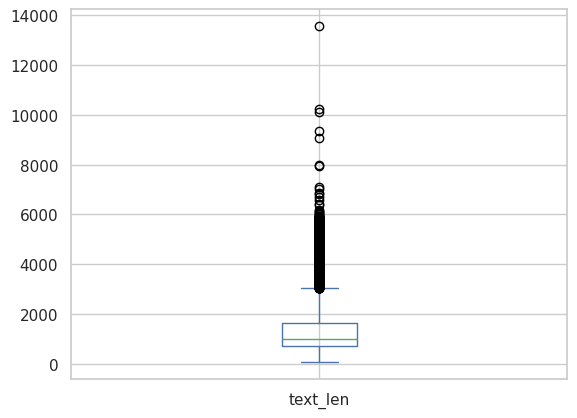

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# boxplot for tain set, label 1
df_train[df_train["label"] == 1]["text_len"].plot(kind="box")

plt.show()

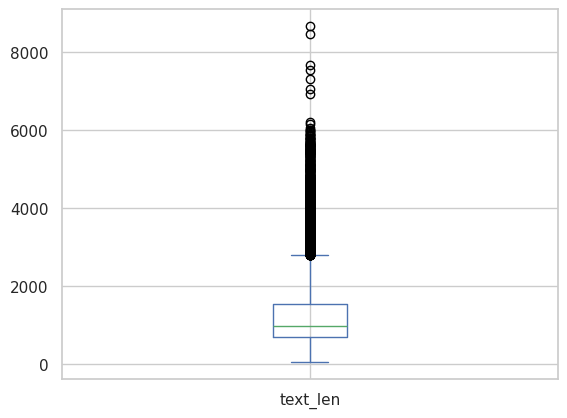

In [12]:
# boxplot for tain set, label 0
df_train[df_train["label"] == 0]["text_len"].plot(kind="box")

plt.show()

In [13]:
df_train["text_len"].describe()

count    24904.000000
mean      1301.903108
std        985.488313
min         52.000000
25%        693.000000
50%        963.000000
75%       1581.000000
max      13584.000000
Name: text_len, dtype: float64

Next, we plot the distribution of the assigned scores to understand the original sentiment of the instances

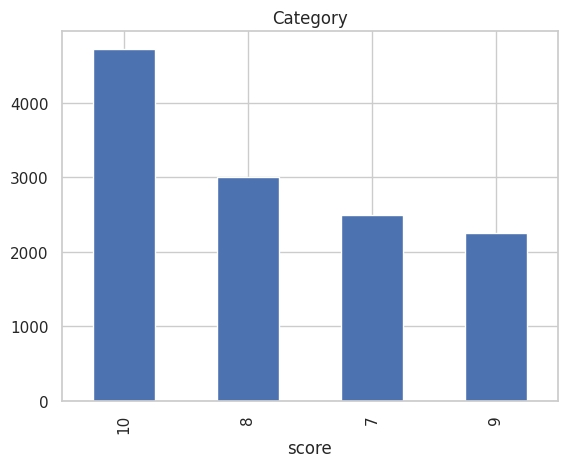

In [14]:
df_train[df_train["label"] == 1]["score"].value_counts().plot(kind='bar', title='Category');

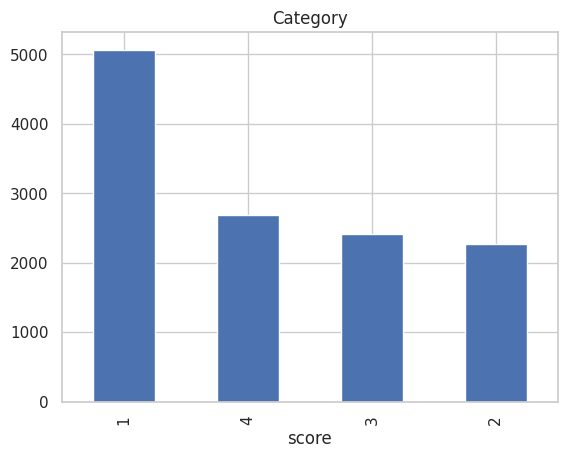

In [15]:
df_train[df_train["label"] == 0]["score"].value_counts().plot(kind='bar', title='Category');

Next, by creating the "WordCloud" plot, we can understand what are the most recurring words in each set

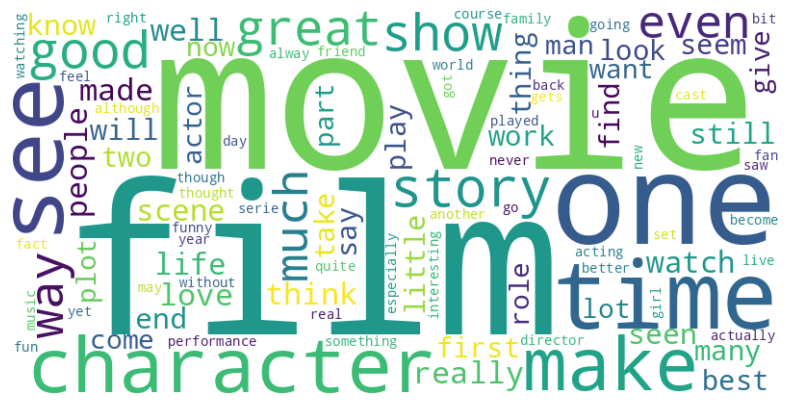

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(" ".join(df_train[df_train["label"] == 1]["text"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

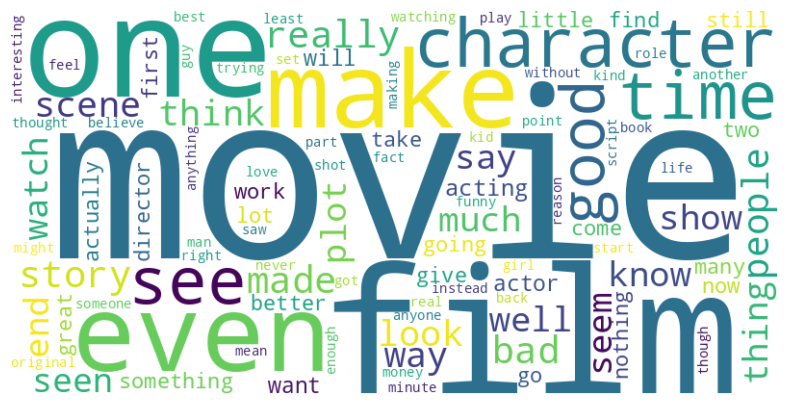

In [18]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(" ".join(df_train[df_train["label"] == 0]["text"]))

# Display the generated word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In summary, the average length of positive reviews and negative reviews is similar. However, positive reviews tend to have more extreme outliers in terms of character length.
The most recurring words are film, movie, one and time. Thus, they are not discriminative for the sentiment. Neverthless, we can say that positive reviews frequently contain words such as "best", "really", and "love".
Some examples of negative reviews are "bad", "acting", and "worst". Probably, the acting is one of the criticized aspect.

### 2.2 Data filtering

Based on the previous results, we removed some outlier reviews in terms of length. The used method is the commonly adopted interquartile range (IRQ) filtering [1], which (i) computer the interquartile range, and (ii) defines a cutoff value based on the lower and upper percentiles. In our case, we use 1.5 as a multiplier to define the cutoff. A value of 3 can be used for a more conservative approach.

The reason behind this filtering step comes from the used approach for feature extraction (i.e., TF-IDF): In particular, filtering out the overly long reviews could help to obtain a more solid feature extraction in terms of word frequency. 

In [19]:
from numpy import percentile


# calculate interquartile range
q25, q75 = percentile(df_train["text_len"], 25), percentile(df_train["text_len"], 75)
iqr = q75 - q25
print("Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f" % (q25, q75, iqr))

# outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# remove outliers
def is_outlier(val):
    return val < lower or val > upper

df_train["is_outlier"] = df_train['text_len'].apply(is_outlier)

print("Num. outliers:", len(df_train.query("is_outlier")))
print("Num. non-outliers:",  len(df_train.query("~is_outlier")))

Percentiles: 25th=693.000, 75th=1581.000, IQR=888.000
Num. outliers: 1863
Num. non-outliers: 23041


In [20]:
df_train.query("is_outlier")["label"].value_counts()

label
1    1032
0     831
Name: count, dtype: int64

In [21]:
print(df_train.query("is_outlier").iloc[0]["text"])

When it comes to movies I can be pretty picky, and I'll complain about anything and everything that is done wrong. While every movie has its flaws, The Night Listener had an exceptionally low count.If you read the last review (it was hard, since half of it was written in caps and it contained no actual information about the movie), you may have been led to believe that this movie was not too well done. Unfortunately, if you read more than 3 lines into that same review, you discovered the poster's reason for disdain: he/she does not like the fact that the director is gay (or that the production team smokes crack...apparently).So, despite the fact that I have never written a review before, I thought this movie deserved one based on its merits, not the sexual orientation of its director. Let's go over a quick checklist first: 1. Great plot? Absolutely. I won't give a shred of it away, but the plot is highly compelling and definitely not what one would expect based on the commercials. This

In [22]:
df_train = df_train.query("~is_outlier").drop(columns=["is_outlier"])
df_train.shape

(23041, 4)

## 3. Feature extraction

The following phase is the feature extraction.
In detail, we adopt the TF-IDF representation to extract the numeric features from the text. Specifically, we define an NLP pipeline that (i) extracts tokens from raw text, (ii) removes stopwords, (iii) normalizes misspelled words, and (iv) extracts lemma/stem from the initial token.
In this way, the text is basically split into words. From there, we remove the non-alphanumeric tokens and remove any stopwords (i.e., common words that are highly recurrent and superfluous). At that point, the misspelled words are fixed (e.g., "gooooooood") and the final token is converted to its base form through stemming or lemmatization.

In [23]:
from typing import List
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import itertools
import enchant
import re
from sklearn.feature_extraction.text import TfidfVectorizer


nlp = spacy.load("en_core_web_sm")

# merge spacy, nltk and sklearn stopwords lists
STOPWORDS = set(list(spacy.lang.en.stop_words.STOP_WORDS) + list(stopwords.words("english")) + list(ENGLISH_STOP_WORDS))

ENGLISH_DICT = enchant.Dict("en_US")

def normalize_word(word) -> str:
    """_summary_
        Normalize word by suggesting a correct word if the word is misspelled or has repeated letters.
        
        _args_:
            word (str): word to normalize
        _returns_:
            str: normalized word
    """

    # remove char repetitions to improve spell check
    # word = re.sub(r'(\w)\1+', r'\1', word)
    word = re.sub(r'(\w)\1+', r'\1\1', word)

    if ENGLISH_DICT.check(word):
        return word
    else:
        suggestions = ENGLISH_DICT.suggest(word)
        if suggestions:
            return suggestions[0]
        else:
            return word


def has_repeated_letters(text, threshold=2) -> bool:
    """_summary_
        Check if text has repeated letters.
        
        _args_:
            text (str): input text
            threshold (int, optional): maximum number of repeated letters. Defaults to 2.

        _returns_:
            bool: True if text has repeated letters, False otherwise
    """
    return any(len(list(s)) > threshold for _, s in itertools.groupby(text))

In [25]:
# Setup NLTK for text processing
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def process_text_nltk(raw_text) -> List[str]:
    """_summary_
        Process text using nltk library to obtain a list of tokens.
        In detail, the following steps are performed:
            1. Tokenize text
            2. Remove punctuation, numbers or stopwords
            3. Normalize misspelled words
            4. Stem tokens
            5. Lowercase tokens

        _args_:
        raw_text (str): input text

        _returns_:
        List[str]: list of tokens
    """

    clean_txt = list()
    ps = PorterStemmer()
    tokens = nltk.word_tokenize(raw_text)
    for token in tokens:
        if token.isalpha() and (token not in STOPWORDS):
            if has_repeated_letters(token):
                token = normalize_word(token)
            t_stem = ps.stem(token.lower())
            clean_txt.append(t_stem.lower())

    return clean_txt

[nltk_data] Downloading package punkt to /home/giovanni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/giovanni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/giovanni/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
# Setup Spacy for text processing
def process_text_spacy(raw_text) -> List[str]:
    """_summary_
        Process text using Spacy library to obtain a list of tokens.
        In detail, the following steps are performed:
            1. Tokenize text
            2. Remove punctuation, numbers or stopwords
            3. Extract lemmas
            4. Normalize misspelled words
            5. Lowercase tokens

        _args_:
        raw_text (str): input text

        _returns_:
        List[str]: list of tokens
    """

    clean_txt = list()

    for token in nlp(raw_text):
        if token.is_alpha and (not token.is_stop):
            token = token.lemma_
            if has_repeated_letters(token):
                token = normalize_word(token)
            clean_txt.append(token.lower())

    return clean_txt

### 2.1 Text normalization

Here we report an example of a "misspelled" word and its normalized form.
In detail, we use the `enchant` library which uses a dictionary to fix those words.

In [27]:
df_train.query("label == 0")["text"].iloc[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [28]:
for t in df_train['text']:
    for sent in t.split("."):
        if "gooo" in sent:
            print(sent)

The movie feels ggooooodd (see the movie to understand), has a very nice feeling, tackles the idea appropriately and better than expected and overall should never have been called slapped together just to save Carrey's career (which wasn't goin' anywhere
 Goodie gooodie, clap clap, what a twist


In [29]:
normalize_word("ggooooodd")

'good'

### 2.3 Vectorizer

We use the `TfidfVectorizer` function from sklearn to compute TF-IDF from the input text. In detail, we implemented a custom function to obtain tokens from text (i.e. to have more control on how the tokens are extracted).
In the following, we compare the performance between the libraries `nltk` and `spacy` to select the most efficient one.

In [30]:
import time

sample_text = df_train['text'].sample(1000)

vect_nltk = TfidfVectorizer(tokenizer=process_text_nltk, strip_accents='ascii', lowercase=False, token_pattern=None)

start = time.time()
vect_nltk.fit(sample_text)
print(int(time.time() - start))


vect_spacy = TfidfVectorizer(tokenizer=process_text_spacy, strip_accents='ascii', lowercase=False, token_pattern=None)

start = time.time()
vect_spacy.fit(sample_text)
print(int(time.time() - start))

2
31


In [31]:
vect = TfidfVectorizer(tokenizer=process_text_nltk, strip_accents='ascii', lowercase=False, token_pattern=None)

In [32]:
vect.fit(df_train['text'])

TfidfVectorizer(lowercase=False, strip_accents='ascii', token_pattern=None,
                tokenizer=<function process_text_nltk at 0x7f9e30d8fd80>)

## 3. Model training and validation

The `nltk`-based vectorizer turned out to be the most efficient. Thus, we proceed with the feature extraction phase by using the `transform()` function using the fitted vectorizer.
We keep the train and test set splitting provided by the input dataset since it is already balanced in terms of classes. However, in that case, an alternative procedure could be to merge the initial train and test set and perform a classic 80-20 random split.
However, it is important to conduct a stratified split since we are considering the accuracy as a comparison metric, which is unreliable in the case of a dataset having unbalanced classes.

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


In [34]:
X_train = vect.transform(df_train['text'])
X_test = vect.transform(df_test['text'])

In [35]:
y_train = df_train['label']
y_test = df_test['label']

In [36]:
# Training
model = LogisticRegression(random_state=1).fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12361
           1       0.87      0.87      0.87     12443

    accuracy                           0.87     24804
   macro avg       0.87      0.87      0.87     24804
weighted avg       0.87      0.87      0.87     24804



### 3.1 Model training

We build and compare different machine learning algorithms, reporting some classic metrics also used in information-retrieval, i.e. accuracy, precision, recall, f1-score and ROC AUC score.

In [37]:
models = [RandomForestClassifier(random_state=1), MultinomialNB(), LogisticRegression(random_state=1), SVC(random_state=1)]

In [38]:
res = list()
preds = list()

for m in models:
    t_start = time.time()
    model = m.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("==> model:", m.__class__.__name__, "- training time (s):", int(time.time() - t_start))
    print(classification_report(y_test, y_pred))
    print()

    preds.append(y_pred)
    res.append({
        "model": model.__class__.__name__,
        "features": "tfidf",
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred)
    })

==> model: RandomForestClassifier - training time (s): 49
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12361
           1       0.85      0.83      0.84     12443

    accuracy                           0.84     24804
   macro avg       0.84      0.84      0.84     24804
weighted avg       0.84      0.84      0.84     24804


==> model: MultinomialNB - training time (s): 0
              precision    recall  f1-score   support

           0       0.79      0.88      0.83     12361
           1       0.86      0.77      0.81     12443

    accuracy                           0.82     24804
   macro avg       0.83      0.82      0.82     24804
weighted avg       0.83      0.82      0.82     24804


==> model: LogisticRegression - training time (s): 3
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12361
           1       0.87      0.87      0.87     12443

    accuracy         

In [39]:
joblib.dump(res, 'res.pkl')
joblib.dump(preds, 'preds.pkl')

['preds.pkl']

### 3.2 Plot results

The best-performing models are *SVC* and *LogisticRegression*, with an accuracy level of 0.87.
In the following, we report some plots and tables (e.g., confusion matrix and bar plots) to compare the obtained results.

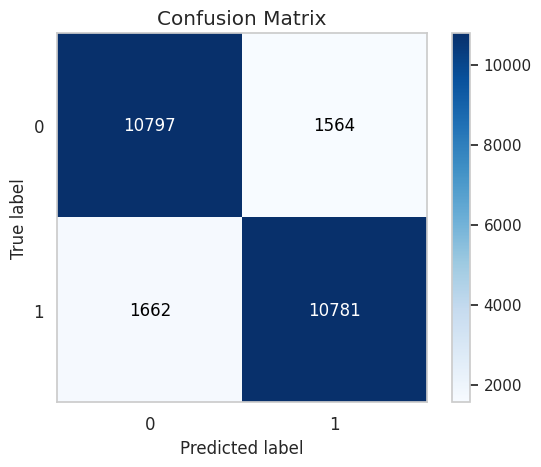

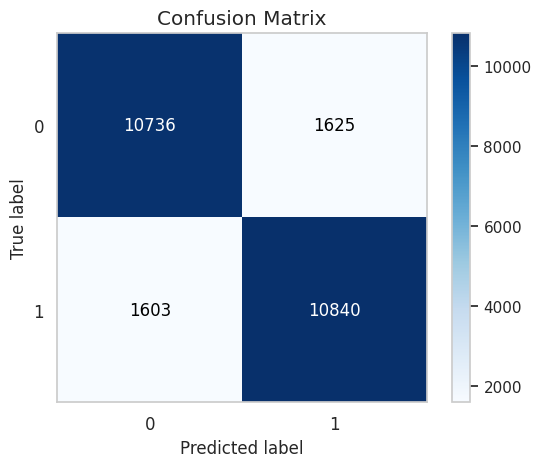

In [40]:
from scikitplot.metrics import plot_confusion_matrix

# confusion matrix for SVC
plot_confusion_matrix(y_test, preds[3]);

# confusion matrix for LogisticRegression
plot_confusion_matrix(y_test, preds[2]);

In [41]:
metrics_df = pd.DataFrame(res).sort_values(by="accuracy", ascending=False)
metrics_df

,model,features,accuracy,precision,recall,f1,roc_auc
3,SVC,tfidf,0.869940,0.873309,0.866431,0.869856,0.869952
2,LogisticRegression,tfidf,0.869860,0.869635,0.871173,0.870403,0.869855
0,RandomForestClassifier,tfidf,0.841558,0.851341,0.828900,0.839971,0.841600
1,MultinomialNB,tfidf,0.821682,0.861848,0.767580,0.811987,0.821861


In [42]:
metrics_df.to_csv("results.csv", index=False)

/tmp/ipykernel_995/2179387834.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_995/2179387834.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


/tmp/ipykernel_995/2179387834.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_995/2179387834.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


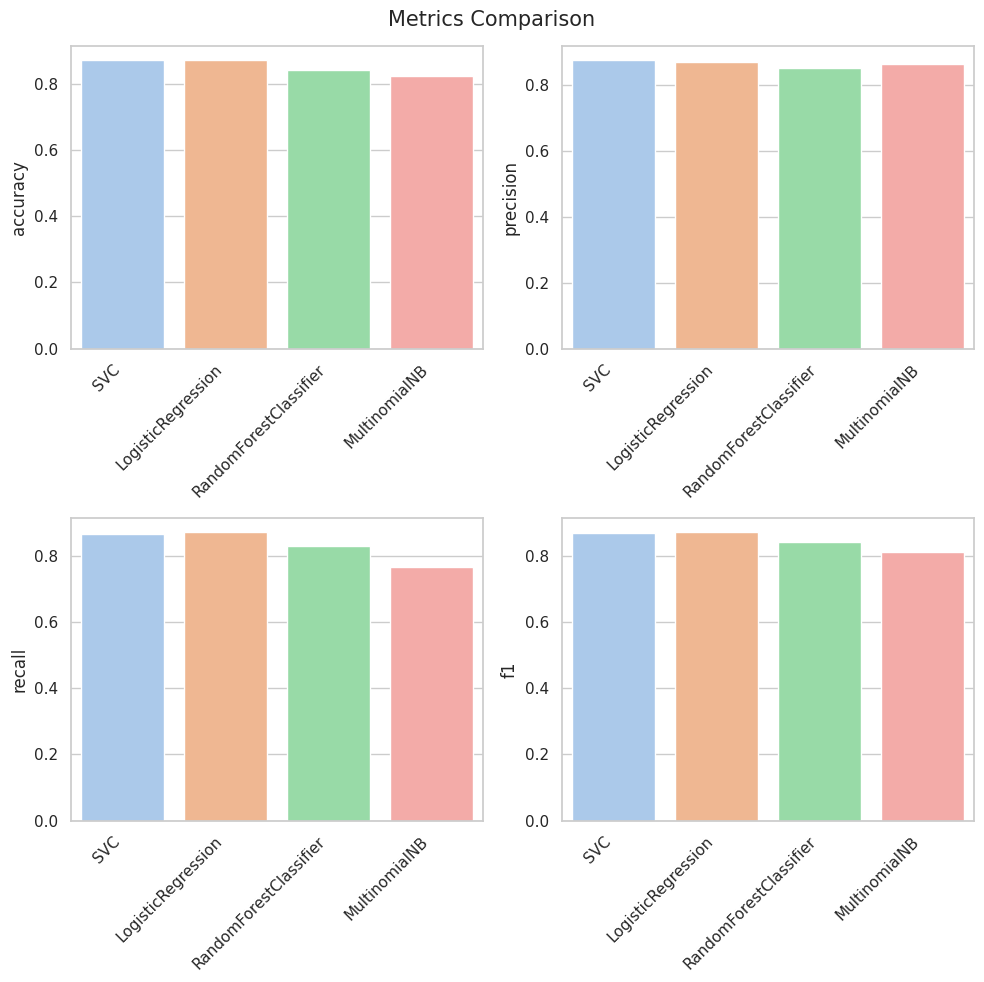

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Create a figure and axes
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 10))
fig.subplots_adjust(hspace=1, wspace=0.4)
fig.suptitle('Metrics Comparison', fontsize=15)

metrics = ['accuracy', 'precision', 'recall', 'f1']

for i in range(n_rows):
    for j in range(n_cols):
        ax = axes[i, j]
        sns.barplot(x='model', y=metrics[i * n_cols + j], data=metrics_df, hue='model', ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


### 3.3 Model tuning

We try to improve the obtained results by optimizing the parameters used in the NLP pipeline, such as considering n-grams [2]. Commonly, model hyperparameter optimization using grid search or random search is applied [3]. However, in that case, we focus more on the feature extraction phase by tuning the parameters used for TF-IDF [4]. In particular, we consider the following parameters:
* `min_df` and `max_df`, which allow excluding the most common and the less common words (i.e., which could be seen as additional stopwords);
* `ngram_range`, considers n-grams other than single tokens in the features vector.

Note: We use *LogisticRegression* for the evaluation since the training time is faster than *SVC*.

In [268]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

t_start = time.time()

# Define the model and hyperparameters to tune
clf_pipeline = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=process_text_nltk, strip_accents='ascii', lowercase=False, token_pattern=None)),
    ("clf", LogisticRegression(random_state=1))
])

# Let's try some common values
param_grid = {
    "vect__min_df": [1, 2, 4, 8],
    "vect__max_df": [0.7, 0.8, 0.9],
    "vect__ngram_range": [(1,1), (1,2), (1,3)],
}

# Create the StratifiedKFold object
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# Create the GridSearchCV object with stratified cross-validation
grid_search = GridSearchCV(clf_pipeline, param_grid, cv=stratified_cv, scoring='accuracy', verbose=1)

# Fit the model to the training data
grid_search.fit(df_train['text'], df_train['label'])

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Time elapsed (seconds)", int(time.time() - t_start))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/home/giovanni/.miniconda3/envs/sentanalysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best hyperparameters:  {'vect__max_df': 0.8, 'vect__min_df': 8, 'vect__ngram_range': (1, 2)}
Best score:  0.8840328806640155
Time elapsed (seconds) 21988


In [282]:
joblib.dump(grid_search, 'grid_search.pkl')

['grid_search.pkl']

The best parameters are:
* `min_df` 8;
* `max_df` 0.8;
* `ngram_range` (1, 2). This means that single words and bi-grams are considered.

We test those parameters with the best-performing model from section 3.1. Since the difference between *SVC* and *LogisticRegression* is negligible, we prefer to select the latter as the training is faster.

In [277]:
vect = TfidfVectorizer(min_df=8, max_df=0.8,  ngram_range=(1,2), tokenizer=process_text_nltk, strip_accents='ascii', lowercase=False, token_pattern=None)
vect.fit(df_train['text'])

TfidfVectorizer(lowercase=False, max_df=0.8, min_df=8, ngram_range=(1, 2),
                strip_accents='ascii', token_pattern=None,
                tokenizer=<function process_text_nltk at 0x7f06e619ff60>)

In [278]:
X_train = vect.transform(df_train['text'])
X_test = vect.transform(df_test['text'])
y_train = df_train['label']
y_test = df_test['label']

We are able to slightly improve the results by obtaining an accuracy of 0.88.

In [279]:
model = LogisticRegression(random_state=1).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12361
           1       0.87      0.88      0.88     12443

    accuracy                           0.88     24804
   macro avg       0.88      0.88      0.88     24804
weighted avg       0.88      0.88      0.88     24804



We also report the confusion matrix and the ROC AUC score, along the ROC curve representing the false positive rate and true positive rate. 

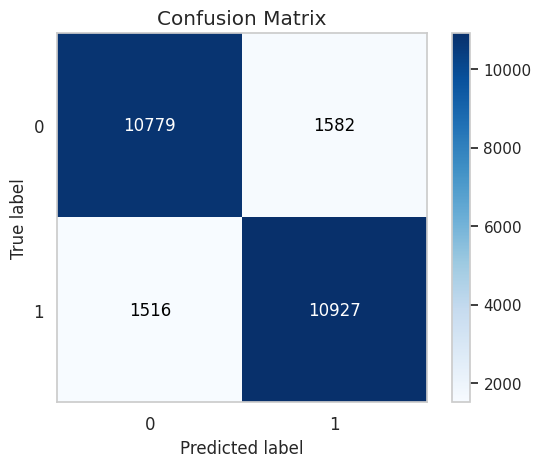

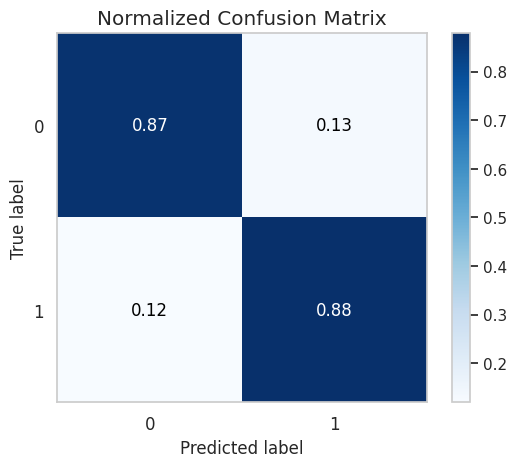

In [280]:
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred);
plot_confusion_matrix(y_test, y_pred, normalize=True);

RCO AUC Score 0.88


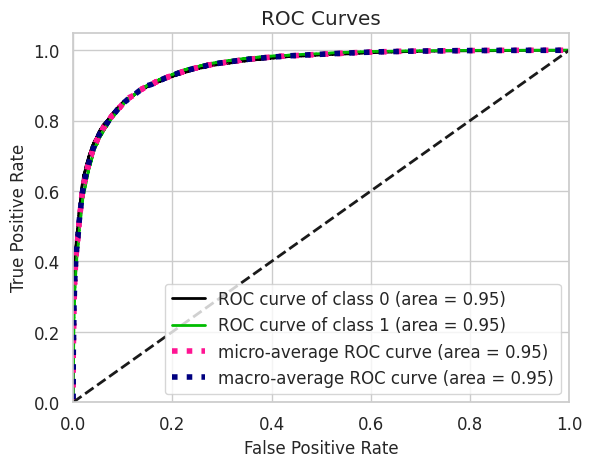

In [281]:
from scikitplot.metrics import plot_roc

plot_roc(y_test, model.predict_proba(X_test));
print("RCO AUC Score", round(roc_auc_score(y_test, y_pred), 2))

**References**
* [1] TowardsDataScience, *Ways to Detect and Remove the Outliers*, https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba (Online: Accessed 19-Dec-2023)
* [2] Scalabrino, S., Bavota, G., Russo, B., Di Penta, M., & Oliveto, R. (2017). Listening to the crowd for the release planning of mobile apps. IEEE Transactions on Software Engineering, 45(1), 68-86.
* [3] scikit-learn, *Tuning the hyper-parameters of an estimator*, https://scikit-learn.org/stable/modules/grid_search.html (Online: Accessed 19-Dec-2023)
* [4] scikit-learn, *TfidfVectorizer*, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html (Online: Accessed 19-Dec-2023)

In [276]:
# Execution environment snapshot
%load_ext watermark
%watermark -vm --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.0
pandas    : 2.1.3
enchant   : 3.2.2
json      : 2.0.9
spacy     : 3.7.2
matplotlib: 3.8.2
nltk      : 3.8.1
numpy     : 1.26.2
scikitplot: 0.3.7
watermark : 2.4.3
re        : 2.2.1
joblib    : 1.3.2

